# 03 Baselines (LogReg & Multinomial NB) + Calibration

Trains baseline models on TF-IDF + numeric features and saves metrics, plots, and the best pipeline.

In [5]:
%run ./00_shared_utils.ipynb
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import joblib, json
set_seeds()

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Shared utilities loaded. Use build_full_pipeline(classifier) to create a text model pipeline.



Training logreg...


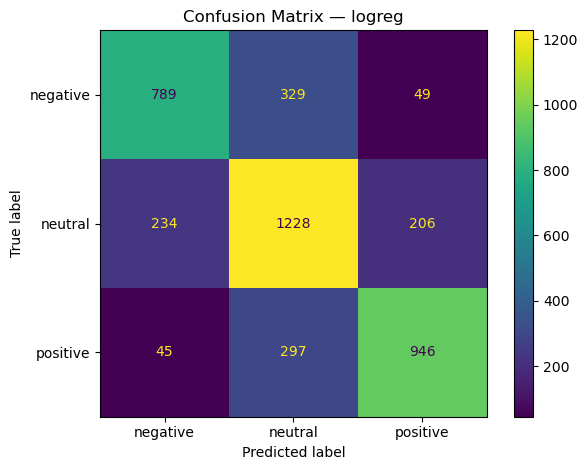

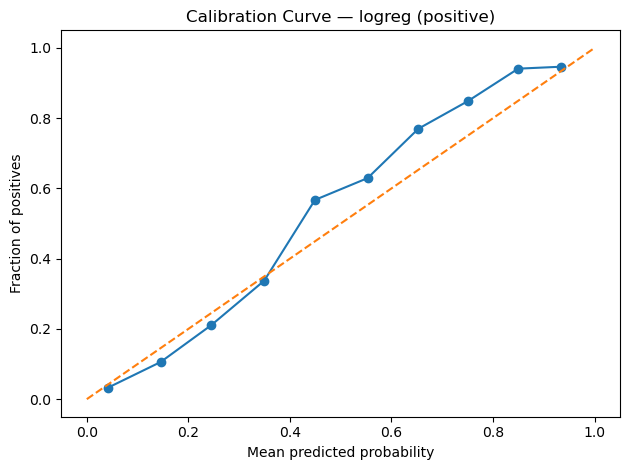


Training mnb...


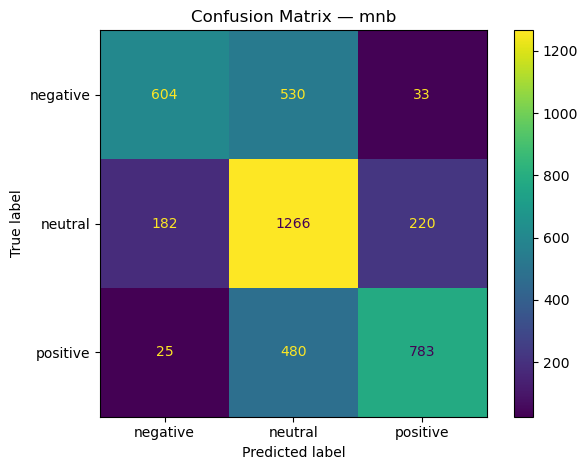

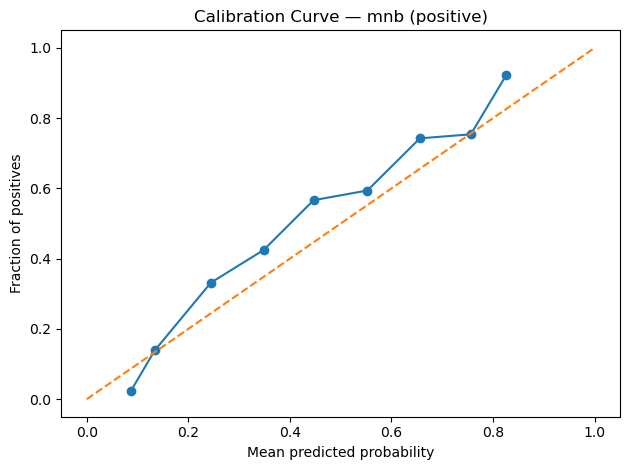

Best: logreg 0.7211719889177287


In [6]:
DATA_PATH = Path('data/Tweets.csv')
df = pd.read_csv(DATA_PATH)

X = df[['text','selected_text']]
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=RANDOM_STATE, stratify=y)

lr = LogisticRegression(max_iter=200, n_jobs=None, solver='saga', random_state=RANDOM_STATE)
nb = MultinomialNB()

pipelines = {
    'logreg': build_full_pipeline(lr),
    'mnb': build_full_pipeline(nb)
}

results = {}
best_name, best_f1 = None, -1
for name, pipe in pipelines.items():
    print(f"\nTraining {name}...")
    pipe.fit(X_train, y_train)

    calib = CalibratedClassifierCV(pipe.named_steps['clf'], method='sigmoid', cv=3)
    feat_pipe = Pipeline(pipe.steps[:-1])
    Xtr = feat_pipe.fit_transform(X_train, y_train)
    calib.fit(Xtr, y_train)

    Xte = feat_pipe.transform(X_test)
    y_pred = calib.predict(Xte)
    y_proba = calib.predict_proba(Xte)

    rep = classification_report(y_test, y_pred, output_dict=True)
    f1_macro = f1_score(y_test, y_pred, average='macro')

    cm = confusion_matrix(y_test, y_pred, labels=calib.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=calib.classes_)
    disp.plot()
    plt.title(f'Confusion Matrix — {name}')
    plt.tight_layout()
    plt.savefig(f'artifacts/{name}_confusion_matrix.png')
    plt.show()

    target_class = 'positive' if 'positive' in calib.classes_ else calib.classes_[0]
    class_idx = list(calib.classes_).index(target_class)
    prob_true, prob_pred = calibration_curve((y_test==target_class).astype(int), y_proba[:, class_idx], n_bins=10)
    plt.figure()
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0,1],[0,1], linestyle='--')
    plt.title(f'Calibration Curve — {name} ({target_class})')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.tight_layout()
    plt.savefig(f'artifacts/{name}_calibration_curve.png')
    plt.show()

    results[name] = {
        'f1_macro': float(f1_macro),
        'report': rep
    }

    if f1_macro > best_f1:
        best_f1 = f1_macro
        best_name = name
        joblib.dump({'features': feat_pipe, 'calib': calib}, f'model_registry/{name}_calibrated_pipeline.joblib')

with open('artifacts/baselines_metrics.json','w') as f:
    json.dump(results, f, indent=2)

print("Best:", best_name, best_f1)